# ECE 670 X1 Mini Project 1

## Task 1 - Mosquito Trap Data and Weather Data

<b>Problem Statement</b>

For Task 1, we were tasked in the creation of 3 regression models using Edmonton weather data and Edmonton Mosquito Trap data. These models were meant to represent a function between the number of observed mosquitoes when considering a number of weather features.

In total, 3 models were created:
1. A linear regression model to represent the number of observed mosquitoes given a number of weather features. 
2. A linear regression model to represent the number of female mosquitoes given the same weather data.
3. A polynomial model to model the number of female mosquitoes given the same weather data.

### Data Pre-processing

Prior to creation of a linear regression model, both data sets (Edmonton Mosquito Trap Data and Edmonton Weather Data) had to be concatenated into a singular data set for analysis. During the initial inspection of the data, the following was observed:
1. Additional logic had to be added to resolve the 'time grid' utilized by the two sets of data. Where the Mosquito Trap Data was sampled at a frequency of one data point per week, Edmonton Weather data was sampled once every hour. 
2. Because Edmonton weather data is an instantaneous measure at the recorded time, some kind of aggregation of the weather data is desired to better match the Mosquito Trap data, such as the utilization and calculation of a moving average for certain features in the weather data set (humidity, temp, dew point, wind_dir_10s, wind_speed, health_index)
3. Within both data sets, some features have inconsistent data and therefore was ignored from the analysis. Columns with limited or no data, such as visibility, cloud cover, humidex, windchill and solar radiation were identified as unncessary to our analysis, and was removed. Similarly, rows with missing data points were also removed from our analysis.
4. For the Edmonton Mosquito Trap data, rows marked with UnID from the IDd column represented bad data and were removed from the analysis. 

<b>Mosquito Data Pre-processing</b>

For the Mosquito Trap data, we inferred that an average of roughly 20 observations were recorded on a weekly basis of the number of female and male mosquitoes that were caught in the recovered mosquito traps that were placedk in various locations in Edmonton. At a glance, it is clear that this data set contains data spanning from 1990 to 2020.

The first desired model takes into account all mosquito genders (male and female) and therefore a method was scripted in order to facilitate ease in isolating parts of the data set we were interested in if we desired (introduction of an optional parameter to isolate either only females or only males). Additionally, the helper functions provided convenience in cleaning the data set in the following ways:
1. The provided trap date column was processed as a datetime object for correct typing
2. Unecessary columns of the mosquito trap data were removed. These columns included the following: 'Comparison Group', 'Genus', 'Specific Epithet', 'Trap Region', 'Latitude', 'Longitude', 'Location', 'IDd', 'Include'
3. Removal of all rows marked as No or No Data in the Include column - from the data set description, values of No or No Data are indicative that the data is of bad quality and therefore should not be considered in our analysis.
4. Summing of the number of mosquitoes on a given date given the mosquito data (all data, female only data, male only data)
5. As our constructed model only requires the number of observed mosquitoes, only the summed number of mosquitoes and trap date is retained in the final data set.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import helper_functions

# Loading of the mosquito trap data set
mosquito_df = pd.read_csv('data_files/Mosquito_Trap_Data.csv')

# Using helper functions to clean mosquito data frame with previously discussed operations
mosquito_df_all = helper_functions.clean_mosquito_df(mosquito_df, gender=None) # both male and female combined
mosquito_df_all

,Count
Trap Date,
1990-05-22,34
1990-05-29,838
1990-06-05,341
1990-06-12,223
1990-06-19,737
...,...
2020-08-25,645
2020-09-01,156
2020-09-08,356


Following the initial clean up of just the mosquito trap data set, there are 578 rows of data, which is significantly lower than the original data set which contained 27263 rows of data. Note that this is still sensible as an average of 20 traps were collected on any given trap date, which reduces the intial row value to approximately 1363 rows of data. Additionally, a total of 829 rows were discarded as these rows were marked as No or No Data in the Include column, which signifies bad quality data. Hence, our remaining data set for the mosquito data was found to have 578 rows of data from the initial data set. 

<b>Edmonton Weather Data Pre-processing</b>

The feature set utilized in the prediction of the number of mosquitoes found on a given trap date was taken from the Edmonton Weather data set. At a first glance of the data set, weather related data was recorded on an hourly time interval for the time period of 2017-2018.

Because the Edmonton weather data consists of instantaneous recordings of Edmonton weather, it was determined that further data processing would be desirable to better relate the weather to the weekly recorded mosquito trap data. Note that in this analysis, we assume that the mosquito traps are collected from various locations on a weekly basis, and as such the number of mosquitoes that are counted are reflective of a weeks worth of mosquitoes landing in the mosquito trap. Because this observed mosquito count value is not an instantaneous value, it is appropriate to attempt to match weather data to the same observed period of time (~ 1 week).

When performing data pre-processing for the weather data set, the following operations were conducted:
1. The provided unixtime column was processed as a datetime object for correct typing
2. Moving averages were calculated for different durations of time (1 day, 7 days, 14 days) for specific weather features ('pressure_station', 'pressure_sea', 'wind_dir_10s', 'wind_speed', 'relative_humidity', 'dew_point', 'temperature')
3. Unecessary columns of the weather data were removed. These columns included the following: 'unixtime', 'wind_dir', 'windchill', 'humidex', 'visibility', 'health_index', 'cloud_cover_4', 'cloud_cover_8', 'cloud_cover_10', 'solar_radiation'

In [53]:
# Load the weather data
weather_df = pd.read_csv('data_files/weather_stats_edmonton.csv')

# Clean weather data and perform preprocessing (performing moving average of 7D)
weather_df = helper_functions.clean_weather_df(weather_df)
weather_df = helper_functions.preprocess_weather(weather_df, ['7D'])

<b>Concatenation of the Two Data Sets</b>

Merging of the two data sets was performed with the intent of matching the trap dates given by the mosquito trap data set. Note that the range of time values given in the weather data set (2017-2018) was not extensive enough to cover the entire period covered by the mosquito trap data (1990-2020). As a result, following the merge of the two data sets, only 41 rows were present in the final merged data set.

**Data Set Limitations**

It is of interest to note that the limited number of samples that we were able to obtain following the merge will likely impact both training and testing of the generated models. Because the limiting data set is the Edmonton weather data, it is suggested that more weather data should be located so that more mosquito trap dates can be utilized for better prediction accuracy. As this was beyond the scope of the Mini Project, retrieval of additional weather data was not conducted; however, it is noted as a limitation for generated model prediction accuracy.

In [56]:
merged_df = helper_functions.merge_mosquito_weather_data(mosquito_df_all, weather_df)

# Removal of columns that reflect instantaenous observations as we will lean towards using moving averages 
# for the creation of the models
instantaneous_weather_recordings = ['pressure_station', 'pressure_sea', 'wind_dir_10s', 'wind_speed',
                                   'wind_gust', 'relative_humidity', 'dew_point', 'temperature']
merged_df.drop(columns=instantaneous_weather_recordings, inplace=True)

# Display the merged data frame
merged_df

,Count,pressure_station_7D,pressure_sea_7D,wind_dir_10s_7D,wind_speed_7D,relative_humidity_7D,dew_point_7D,temperature_7D
Trap Date,,,,,,,,
2017-05-09,26,93.154405,101.023214,17.732143,12.922619,59.267857,3.150595,12.089881
2017-05-16,29,93.794464,101.717857,18.214286,11.303571,53.047619,1.845833,12.664286
2017-05-23,523,93.174881,100.979762,21.898810,14.404762,47.815476,3.657738,16.151190
2017-05-30,360,93.169167,100.948214,21.922619,14.767857,53.285714,7.225595,17.898214
2017-06-06,1649,92.997976,100.784524,18.130952,14.380952,58.047619,7.180357,16.838095
2017-06-13,2959,93.148036,100.966071,23.494048,10.785714,62.095238,7.415476,15.584524
2017-06-20,1868,93.819048,101.679762,24.136905,17.154762,52.720238,5.867262,16.400595
2017-06-27,767,93.248274,101.032738,23.863095,12.636905,65.476190,10.693452,18.035119
2017-07-04,1776,93.831667,101.620238,17.142857,11.345238,54.321429,10.501786,20.857143


<AxesSubplot:xlabel='temperature_7D', ylabel='Count'>

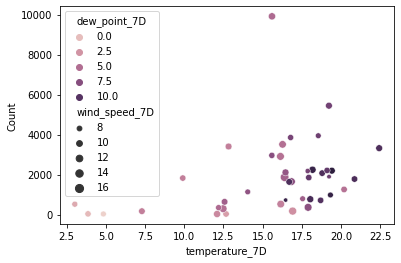

In [57]:
sns.scatterplot(data=merged_df, x='temperature_7D', y='Count', hue='dew_point_7D', size='wind_speed_7D')

### Regression Models

The first model of interest is the creation of a linear regression model that predicts the number of mosquitoes (in the collected mosquito traps) based on observed Edmonton weather features. For this analysis, the total number of mosquitoes are used.

<b>1. Number of Mosquitos vs. Weather Features (Linear Regression)</b>

To facilitate training of the model, we must first divide our limited data samples into a training and testing set. The training set consists of 70% of the data, while the validation/testing set consists of the remaining 30% of the data.

In [64]:
from sklearn.model_selection import train_test_split

# Define feature set (weather features) and resulting output (number of mosquitoes)
X = merged_df.drop(columns=['Count'])
Y = merged_df['Count']

# Split data into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X , Y , test_size = 0.3, random_state = 0)

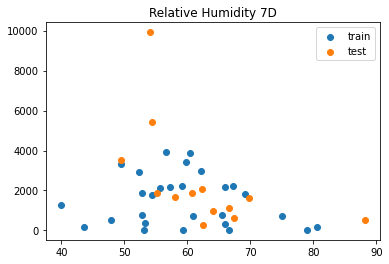

In [65]:
# Plotting one of the features
plt.scatter(X_train['relative_humidity_7D'], Y_train,label='train')
plt.scatter(X_test['relative_humidity_7D'],Y_test, label='test')
plt.title('Relative Humidity 7D')
plt.legend();

Use different cost functions, perform analysis of constructed models, apply normalization and
standardization, feature selection.

In [74]:
from sklearn import linear_model

lreg = linear_model.LinearRegression()
lreg.fit(X_train, Y_train)

# Apply normalization and standardization
# Different cost functions?
# Feature selection?

LinearRegression()

In [75]:
wsk = lreg.intercept_,lreg.coef_[0]
wsk

(668.8776133491525, -148.85296348770473)

In [ ]:
# Placeholder for model analysis

<b>2. Number of Female Mosquitos vs. Weather Features (Linear Regression)</b>

In [66]:
# Isolation of the female mosquito data set for part b of the first task
mosquito_df_female = helper_functions.clean_mosquito_df(mosquito_df, gender='Female')

# Merging of the female mosquito and weather data set
merged_df = helper_functions.merge_mosquito_weather_data(mosquito_df_female, weather_df)

In [67]:
# Re-initialize the merged data

X = merged_df.drop(columns=['Count'])
Y = merged_df['Count']

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split( X , Y , test_size = 0.3, random_state = 0)

Use different cost functions, perform analysis of constructed models, apply normalization and
standardization, feature selection.

In [69]:
sklreg = linear_model.LinearRegression()
sklreg.fit(X_train,Y_train)

LinearRegression()

In [70]:
# Using Standardization
from sklearn.preprocessing import StandardScaler
X_train_scaled = StandardScaler().fit_transform(X_train)

sklreg.fit(X_train_scaled, Y_train)

LinearRegression()

In [71]:
Y_pred_sk = sklreg.predict(X_test)

<b>Model C: Number of Female Mosquitos vs. Weather Features (Polynomial Regression)</b>

The third constructed model is polynomial regression. Polynomial regression is similar to linear regression; however, **continue blurb here**

<b>Feature Selection</b>

In [22]:
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split

X = merged_df.drop(columns=['Count'])
Y = merged_df['Count']

X_train, X_test, Y_train, Y_test = train_test_split( X , Y , test_size = 0.3, random_state = 0)

For regression analysis, an F-test should be performed to ascertain the most significant features of the data set. This is done to remove features that do not contribute to the model's performance and determine which features are most signifant prior to proceeding to our final analysis. In particular, the F-test estimates the degree to which there is a linear dependency between two random variables when comparing their variances (in our case, the feature set and the output lable), and the p value allows us to determine significance through the validation or rejection of the null hypothesis. The null hypothesis assumes that there is no relationship between a given input feature and an output. 

In [23]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [24]:
F_test,p_value = f_regression(X_poly,Y)
pd.DataFrame({'feature':poly_features.get_feature_names(),
              'F_test':F_test,'p_value':p_value})

,feature,F_test,p_value
0,x0,0.370846,0.546075
1,x1,0.715319,0.402843
2,x2,0.082041,0.776066
3,x3,1.998402,0.165398
4,x4,0.000401,0.984134
...,...,...,...
4954,x26 x28^2,12.761225,0.000960
4955,x27^3,7.701968,0.008426
4956,x27^2 x28,10.631833,0.002311
4957,x27 x28^2,13.445303,0.000731


Following the F-test and p value analysis, selection of the best features is performed. 

In [25]:
from sklearn.feature_selection import SelectKBest

X_best = SelectKBest(f_regression).fit_transform(X_poly, Y)

In [26]:
X_poly.shape, X_best.shape

((41, 4959), (41, 10))

In [27]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)

sklreg_poly = linear_model.LinearRegression()
sklreg_poly.fit(X_train_poly,Y_train)

Xl = np.linspace(0, 1, 100).reshape(100,1)
Xl_poly = poly_features.fit_transform(Xl)

# Y_pred = sklreg_poly.predict(Xl_poly)
# plt.scatter(X_train,Y_train)
# plt.plot(Xl,Y_pred,'r');

sklreg_poly.score(X_train_poly,Y_train),sklreg_poly.score(poly_features.fit_transform(X_test),Y_test)

(1.0, -0.22706995504147098)

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def plot_models(X,Y,X_test, Y_test, degrees):
    for i,degree in enumerate(degrees):
        ax = plt.subplot(1, len(degrees), i + 1)
        poly_features = PolynomialFeatures(degree=degree)
        sklreg = linear_model.LinearRegression()
        pipeline = Pipeline([("polynomial_features", poly_features),
                             ("linear_regression", sklreg)])
        pipeline.fit(X,Y)
        Y_pred = pipeline.predict(X)
        plt.plot(X_test, pipeline.predict(X_test), label="Model")
        plt.scatter(X, Y, edgecolor='b', s=20, label="Samples")
        plt.scatter(X_test, Y_test, edgecolor='r',s=15, label="Test")
        plt.xlabel("x")
        plt.title("Degree {}".format(degree))
        plt.legend(loc="best")